AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations

ARIMA(1,1,0) = differenced first-order autoregressive model: If the errors of a random walk model are autocorrelated, perhaps the problem can be fixed by adding one lag of the dependent variable to the prediction equation--i.e., by regressing the first difference of Y on itself lagged by one period. This would yield the following prediction equation:

Ŷt - Yt-1  =  μ  +  ϕ1(Yt-1 - Yt-2)

Ŷt  - Yt-1   =  μ

which can be rearranged to

Ŷt  =  μ  + Yt-1  +  ϕ1 (Yt-1 - Yt-2)

This is a first-order autoregressive model with one order of nonseasonal differencing and a constant term--i.e., an ARIMA(1,1,0) model.

In [1]:
import pandas as pd
import os
import matplotlib.cm as cm
from matplotlib.offsetbox import AnchoredText as at
import numpy as np
from pandas import datetime
from matplotlib import pyplot
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
All = pd.read_csv("SalesALLNew.csv",encoding = "ISO-8859-1")
All['LINETOTAL'].sum()

38309121.411393

In [4]:
All['LINETOTAL'].sum()
All['ZIPCODE'] = All['ZIPCODE'].str[:5]
#All['SHIP_TO_ZIP'].value_counts()
#All['CUST_TYPE_ID'] = pd.to_int(All['CUST_TYPE_ID'])
All['CUST_TYPE_ID'] = All['CUST_TYPE_ID'].fillna(0)
All['CUST_TYPE_ID'] = All['CUST_TYPE_ID'].astype(int)
All['LINETOTAL'] = np.log(All['LINETOTAL']) / 2
All.info()
All['CUST_TYPE_ID'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 7 columns):
DATE_TAKEN       72134 non-null object
ORDERNO          72132 non-null float64
LINETOTAL        72134 non-null float64
COMPANY          72134 non-null object
SHIP_TO_STATE    70688 non-null object
ZIPCODE          71344 non-null object
CUST_TYPE_ID     72134 non-null int32
dtypes: float64(2), int32(1), object(4)
memory usage: 3.6+ MB


array([ 2,  0,  1, 12,  7, 15,  5,  6,  4, 11,  3, 13], dtype=int64)

In [5]:
All['Year'] = pd.DatetimeIndex(All['DATE_TAKEN']).year
All['Month'] = pd.DatetimeIndex(All['DATE_TAKEN']).month.astype(str)
All['Month'] = All['Month'].str.zfill(2)
All['YearMonth'] = All["Year"].map(str) + '-' + All["Month"].map(str)
All['YearMonth2'] = All["Year"].map(str) + All["Month"].map(str)
All.head()

,DATE_TAKEN,ORDERNO,LINETOTAL,COMPANY,SHIP_TO_STATE,ZIPCODE,CUST_TYPE_ID,Year,Month,YearMonth,YearMonth2
0,1/15/2016,367357.0,1.319529,BENNETT RACING,AL,35565,2,2016,01,2016-01,201601
1,1/15/2016,367358.0,1.319529,AUSTIN LONES,FL,32566,0,2016,01,2016-01,201601
2,1/15/2016,367358.0,1.868835,AUSTIN LONES,FL,32566,0,2016,01,2016-01,201601
3,1/15/2016,367357.0,3.280416,BENNETT RACING,AL,35565,2,2016,01,2016-01,201601
4,1/15/2016,367359.0,1.589027,WEBORDERS,CA,94571,0,2016,01,2016-01,201601


In [6]:
FinalAll = All[['ORDERNO','LINETOTAL','YearMonth','YearMonth2','SHIP_TO_STATE','ZIPCODE','CUST_TYPE_ID']].copy()
#FinalAll.rename(columns={'SHIP_TO_ZIP': 'ZipCode'}, inplace=True)
#FinalAll['TotalDollars'] = pd.DataFrame(All.groupby('SHIP_TO_STATE')['LINETOTAL'].sum())

FinalAll.head()

,ORDERNO,LINETOTAL,YearMonth,YearMonth2,SHIP_TO_STATE,ZIPCODE,CUST_TYPE_ID
0,367357.0,1.319529,2016-01,201601,AL,35565,2
1,367358.0,1.319529,2016-01,201601,FL,32566,0
2,367358.0,1.868835,2016-01,201601,FL,32566,0
3,367357.0,3.280416,2016-01,201601,AL,35565,2
4,367359.0,1.589027,2016-01,201601,CA,94571,0


In [7]:
CUSTS = ['12','13','14','15']

FinalAll = FinalAll[~All.CUST_TYPE_ID.isin(CUSTS)]

FinalAll['LINETOTAL'] = FinalAll['LINETOTAL']/3

In [8]:
Series = FinalAll[['YearMonth','LINETOTAL']].copy()
#Series['YearMonth'] = Series['YearMonth'] + str('-01')
Series['YearMonth'] = Series['YearMonth'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%'))
Series.head()

,YearMonth,LINETOTAL
0,2016-01-01,0.439843
1,2016-01-01,0.439843
2,2016-01-01,0.622945
3,2016-01-01,1.093472
4,2016-01-01,0.529676


In [9]:
SeriesGroup = Series.groupby('YearMonth')['LINETOTAL'].sum()
SeriesGroup

YearMonth
2016-01-01    1456.205232
2016-02-01    1878.203705
2016-03-01    2304.491339
2016-04-01    2054.248784
2016-05-01    2149.262117
2016-06-01    2059.606521
2016-07-01    1841.300543
2016-08-01    2163.856261
2016-09-01    1800.795389
2016-10-01    1811.506947
2016-11-01    1829.341747
2016-12-01    1538.735746
2017-01-01    1815.815614
2017-02-01    1973.374533
2017-03-01    2688.610315
2017-04-01    2265.529148
2017-05-01    2424.756731
2017-06-01    2217.078922
2017-07-01    1959.075648
2017-08-01    2246.172740
2017-09-01    1807.745879
2017-10-01    1824.615348
2017-11-01    1773.994670
2017-12-01    1575.531337
2018-01-01    2412.947589
Name: LINETOTAL, dtype: float64

NameError: name 'plt' is not defined

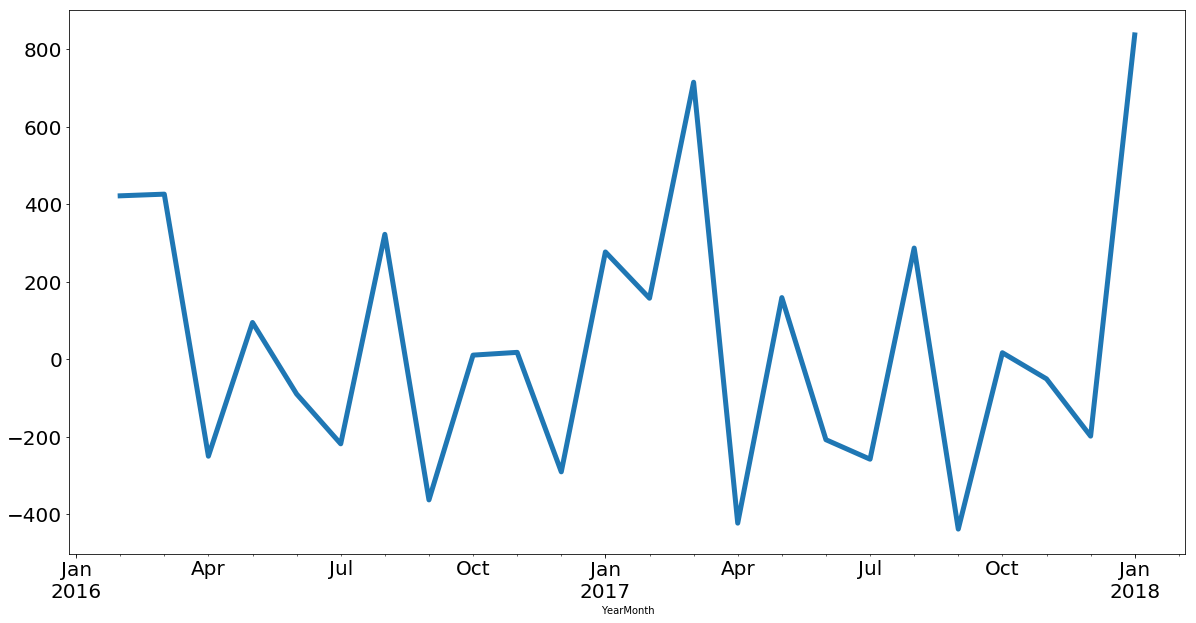

In [11]:
SeriesGroup.diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.show()

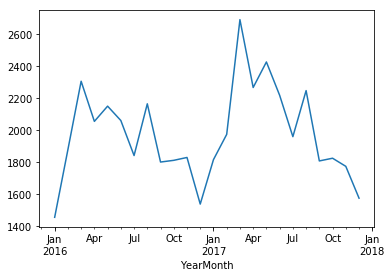

In [12]:
SeriesGroup[:-1].plot()
pyplot.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


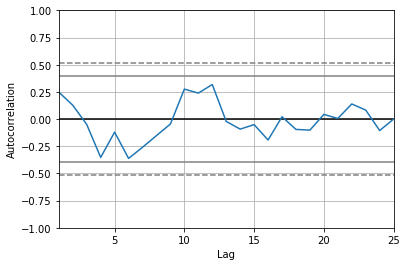

In [13]:
autocorrelation_plot(SeriesGroup)
pyplot.show()

In [28]:
# fit model
model = ARIMA(SeriesGroup, order=(0,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.LINETOTAL   No. Observations:                   24
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -172.386
Method:                       css-mle   S.D. of innovations            317.287
Date:                Fri, 08 Jun 2018   AIC                            350.772
Time:                        14:49:54   BIC                            354.306
Sample:                    02-01-2016   HQIC                           351.709
                         - 01-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                18.4361     41.667      0.442      0.662     -63.230     100.103
ma.L1.D.LINETOTAL    -0.4178      0.298     -1.403      0.174      -1.001       0.166
                        

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:            D.LINETOTAL   No. Observations:                   24
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -170.799
Method:                       css-mle   S.D. of innovations            283.314
Date:                Fri, 08 Jun 2018   AIC                            349.598
Time:                        14:50:34   BIC                            354.310
Sample:                    02-01-2016   HQIC                           350.848
                         - 01-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 9.6516     12.565      0.768      0.451     -14.976      34.279
ar.L1.D.LINETOTAL     0.3859      0.223      1.729      0.099      -0.052       0.823
ma.L1.D.LINETOTAL    -1.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


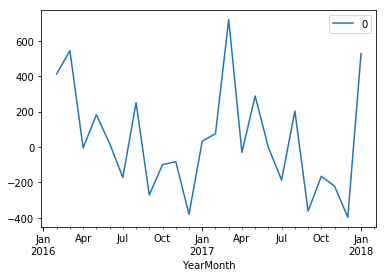

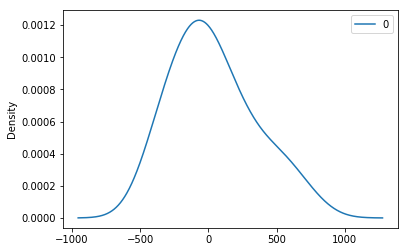

                0
count   24.000000
mean    36.421429
std    303.424508
min   -396.930405
25%   -175.817268
50%     -4.148647
75%    214.707435
max    718.397641
[2215.16663617]


In [30]:
# fit model
model = ARIMA(SeriesGroup, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())
output = model_fit.forecast()[0]
print(output)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=2472.351687, expected=2424.756731
predicted=2446.450226, expected=2217.078922
predicted=2340.516952, expected=1959.075648
predicted=2061.390370, expected=2246.172740
predicted=2205.153845, expected=1807.745879
predicted=1988.387341, expected=1824.615348
predicted=1836.085261, expected=1773.994670
predicted=1804.210278, expected=1575.531337
predicted=1642.019259, expected=2412.947589
Test MSE: 118861.402


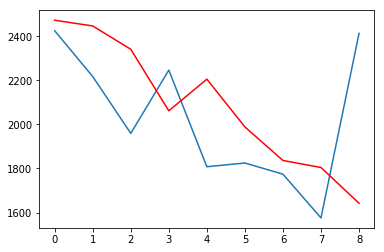

In [32]:
X = SeriesGroup.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

                0
count   24.000000
mean    36.421429
std    303.424508
min   -396.930405
25%   -175.817268
50%     -4.148647
75%    214.707435
max    718.397641
[365.16322174]
Forecast: 2338.537755


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


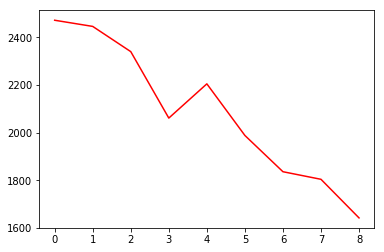

In [33]:
# create a differenced series
def difference(SeriesGroup, interval=1):
	diff = list()
	for i in range(interval, len(SeriesGroup)):
		value = SeriesGroup[i] - SeriesGroup[i - interval]
		diff.append(value)
	return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load dataset
#series = Series.from_csv('dataset.csv', header=None)
# seasonal difference
X = SeriesGroup.values
months_in_year = 12
differenced = difference(X, months_in_year)
# fit model
model = ARIMA(differenced, order=(1,1,0))
model_fit = model.fit(disp=0)
# one-step out-of sample forecast
forecast = model_fit.forecast(steps=1)[0]
# invert the differenced forecast to something usable
forecast = inverse_difference(X, forecast, months_in_year)
print(residuals.describe())
output = model_fit.forecast()[0]
print(output)
print('Forecast: %f' % forecast)
#pyplot.plot(difference)
pyplot.plot(predictions, color='red')
#pyplot.plot(residuals)
pyplot.show()


In [34]:
SeriesGroup[:-1]

YearMonth
2016-01-01    1456.205232
2016-02-01    1878.203705
2016-03-01    2304.491339
2016-04-01    2054.248784
2016-05-01    2149.262117
2016-06-01    2059.606521
2016-07-01    1841.300543
2016-08-01    2163.856261
2016-09-01    1800.795389
2016-10-01    1811.506947
2016-11-01    1829.341747
2016-12-01    1538.735746
2017-01-01    1815.815614
2017-02-01    1973.374533
2017-03-01    2688.610315
2017-04-01    2265.529148
2017-05-01    2424.756731
2017-06-01    2217.078922
2017-07-01    1959.075648
2017-08-01    2246.172740
2017-09-01    1807.745879
2017-10-01    1824.615348
2017-11-01    1773.994670
2017-12-01    1575.531337
Name: LINETOTAL, dtype: float64

In [55]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
import numpy
history = []
Fore=[]
# load dataset
SeriesGroup
# seasonal difference
#X = SeriesGroup.values
X = SeriesGroup[:-1].values
months_in_year = 12
differenced = difference(X, months_in_year)
# fit model
model = ARIMA(differenced, order=(1,1,0))
model_fit = model.fit(disp=0)
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=6)[0]
# invert the differenced forecast to something usable
history = [x for x in X]
month = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, months_in_year)
    Fore.append('%f' %inverted)
    history.append(inverted)
    month += 1
Fore1 = pd.DataFrame(Fore)
Fore1.to_csv('Pres2',encoding='utf-8')
Fore1

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


,0
0,1725.769208
1,1950.227772
2,2560.954741
3,2185.014446
4,2257.214336
5,2081.211383


In [50]:
# create a differenced series
split_point = len(SeriesGroup) - 12
dataset, validation = SeriesGroup[0:split_point], SeriesGroup[split_point:]
history = [x for x in dataset]
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

In [51]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [52]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
import numpy
from pandas import datetime
 

# load dataset
series = dataset
# seasonal difference
X = SeriesGroup[:-1].values
months_in_year = 12
differenced = difference(X, months_in_year)
# fit model
model = ARIMA(differenced, order=(1,1,0))
model_fit = model.fit(disp=0)
# one-step out of sample forecast
start_index = len(differenced)
end_index = len(differenced)
forecast = model_fit.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
forecast = inverse_difference(X, forecast, months_in_year)
print('Forecast: %f' % forecast)
forecast = model_fit.forecast(steps=7)[0]
history = [x for x in X]
month = 19
for yhat in forecast:
	inverted = inverse_difference(history, yhat, months_in_year)
	print('Month %d: %f' % (month, inverted))
	history.append(inverted)
	month += 1

Forecast: 1688.973616
Month 19: 1725.769208
Month 20: 1950.227772
Month 21: 2560.954741
Month 22: 2185.014446
Month 23: 2257.214336
Month 24: 2081.211383
Month 25: 1749.863616


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [53]:
print(validation)

YearMonth
2017-02-01    1973.374533
2017-03-01    2688.610315
2017-04-01    2265.529148
2017-05-01    2424.756731
2017-06-01    2217.078922
2017-07-01    1959.075648
2017-08-01    2246.172740
2017-09-01    1807.745879
2017-10-01    1824.615348
2017-11-01    1773.994670
2017-12-01    1575.531337
2018-01-01    2412.947589
Name: LINETOTAL, dtype: float64
